# **Neural Network Building Blocks**

### defining a function & a Loss (MAE)

In [1]:
PURPOSE = """in this code I want to show how accurate gradient descent works 
for that purpose I will do these steps:
1. make a function (so we can recreat it with GD)
2. make a data with noise 
3. recreat the original function won that data with GD
(source: fast.ai course pt.3)
"""

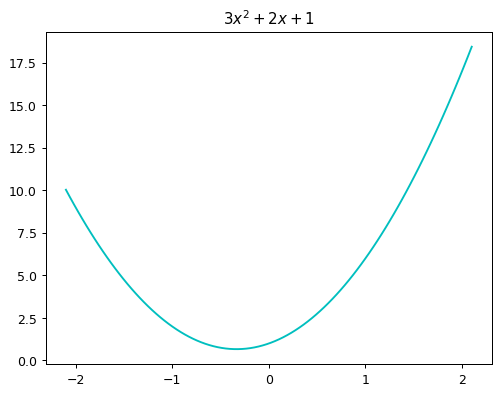

In [2]:
#plotting a quadratic
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def f(x): 
    f=3*x**2 + 2*x + 1 #a quadratic equation ax^2+bx+c ; a=3, b=2, c=1
    return f

def plot_function(f, title=None, min=-2.1, max=2.1, color='c', ylim=None):
    x=torch.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)
    plt.title(title)

plot_function(f, "$3x^2 + 2x + 1$")

In [3]:
#the value of a point in the quadratic:
def quad(a,b,c,x):
    y= a*x**2+b*x+c
    return y

quad(3,2,1,2)

17

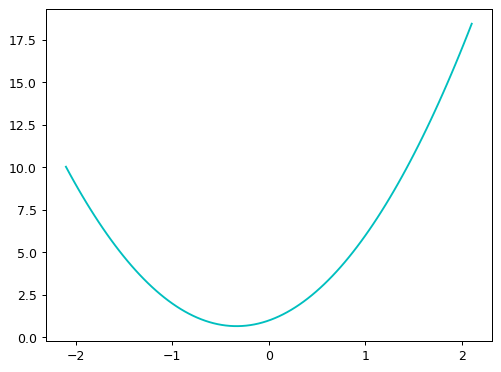

In [4]:
#recreating the quadratic with fixed a/b/c & variable x (using partial)
def fixedparameters_quadratic(a,b,c): 
    equation=partial(quad, a,b,c)
    return equation

f_example=fixedparameters_quadratic(3,2,1)
plot_function(f_example)
#as we see it works the same as the previous shells

In [5]:
#making noisy data
def noise(x, scale): 
    #generating rand num from a standard normal distributiona(SND)(higher scale : bigger spread)
    noise=torch.randn_like(x) * scale 
    #torch.randn_like(x): creates a tensor with x shape, filled with rand num of SND
    return noise

def add_noise(x, mult, add): 
    adjustednoise=x*(1+noise(x,mult)) +noise(x,add) #That 1+ ensures we scale x by close to 1 (not replacing it)
    #mult: scale of multiplicative noise / add:scale of additive noise
    return adjustednoise


P.S = """why did we used that specific structure ((1 + mult_noise)x + add_noise) for adjustednoise & not something else?

- Multiplicative noise: change the scale of the signal (simulate things like gain fluctuation) &
- Additive noise: add random values regardless of the signal's strength(Simulates background interference)
this combo is popular because it's versatile, realistic & many real signals (e.g.images & sound) have them both
"""

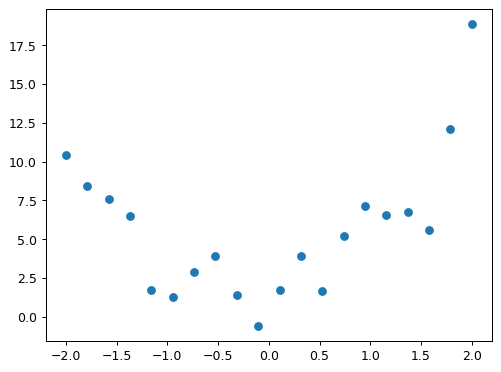

In [6]:
#plotting
np.random.seed(42) #making the noise and plot the same so we can compare results easier

x3=torch.linspace(-2, 2, steps=20)[:,None]
y3=add_noise(f(x3), 0.15, 1.5)

plt.scatter(x3,y3)
plt.show()

In [7]:
#finding(adjusting) a/b/c manually
@interact(a=1.1, b=1.1, c=1.1) #this will make adjustment sliders for the later def
def plotting_quadratic(a, b, c):
    plt.scatter(x3,y3)
    plot_function(fixedparameters_quadratic(a,b,c), ylim=(-3,13))
#but this is a bit blind...

NOTE= """ to see the interactive graphs rerun the code """

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [8]:
#defining a numeric measurment of how the fitting is good()
def meanabsolute_error(preds, acts): 
    mse=(torch.abs(preds-acts)).mean()
    return mse

#mean absolute error measure the distance from each data point to the curve

In [9]:
#now by changing the sliders we can see how MSE change too (so we can adjust them more wisely now)
@interact(a=1.1, b=1.1, c=1.1)

def plotting_quadratic(a, b, c):
    f=fixedparameters_quadratic(a,b,c)
    plt.scatter(x3,y3)
    loss=meanabsolute_error(f(x3), y3)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

NOTE= """ to see the interactive graphs rerun the code """

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [36]:
#lets see if that MAE value on graph is true
def quad_mae(params):
    f=fixedparameters_quadratic(*params)
    return mae(f(x3), y3)

"""we can see by giving it the values of a/b/c in sliders we get the same result"""
quad_mae([2.7, 1.0, 1.6])

TensorBase(1.3942)

### Gradient Descent Manually

In [37]:
""" calculatin gradients for an arbitrary initial a/b/c so we can make it better by reducing the loss"""
#an arbitrary initial values for a/b/c
abc=torch.tensor([3.3, 2.3, 0.3]) 
abc.requires_grad_() #we are telling PyTorch that we want it to calculate gradients for these parameters

#loss
#we are trying to minimize the loss so lets calculate it for the initial values so then we can calculate it after GD and see if it works
loss = quad_mae(abc)
print(f'Initial loss: {loss.item():.2f}')

Initial loss: 1.98


In [38]:
# this'll show us how much the initial a/b/c should change 
loss.backward()
# Explain the meaning of gradient signs
print("Gradients of abc:", abc.grad)
#when the grad is -/+ it means we should decrese/increase that parameter 

Gradients of abc: tensor([-0.4199,  0.5158, -0.3000])


In [39]:
# Gradient descent

with torch.no_grad():
    abc-=abc.grad*0.1
abc=abc.detach().requires_grad_()
loss=quad_mae(abc)
    
print(f'loss={loss.item():.2f}')
#We can see that the loss is getting lower 

loss=1.93


In [40]:
#make a loop for GD so we get it lower & lower
for i in range(10):
    loss=quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.1
    print(f'step={i}; loss={loss.item():.2f}')

step=0; loss=1.93
step=1; loss=1.88
step=2; loss=1.81
step=3; loss=1.74
step=4; loss=1.77
step=5; loss=1.78
step=6; loss=1.80
step=7; loss=1.80
step=8; loss=1.76
step=9; loss=1.67


In [41]:
NOTES= """As you can see, our loss keeps going down!
If we keep running this loop for long enough, you'll see that the loss will increase.
That's because once the parameters get close to the correct answer, our parameter updates will jump right over the correct answer(it is the min of function) 
To avoid this, we need to decrease our learning rate as we train. 
this is done using a learning rate schedule."""

### Relu (1 layer Neural Network)

In [45]:
STARTING_NOTES= """but we cam do more than just a quadratic with NN because it can approximate any func given by 2 step:
1. matrix multiplication & 2.the max(x,0) (which replce negative values with 0)
in PyTorch we call the max(x,0) as np.clip(x,0) 
& linear func + max(x,0) is called a RECTIFIED LINEAR FUNCTION"""

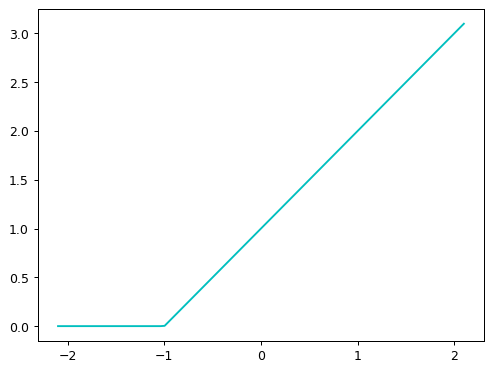

In [44]:
#this is how a linear rectifier looks like
def rectified_linear(m1,b1,x):
    y=m1*x+b1
    return torch.clip(y, 0.)
plot_function(partial(rectified_linear, 1,1))

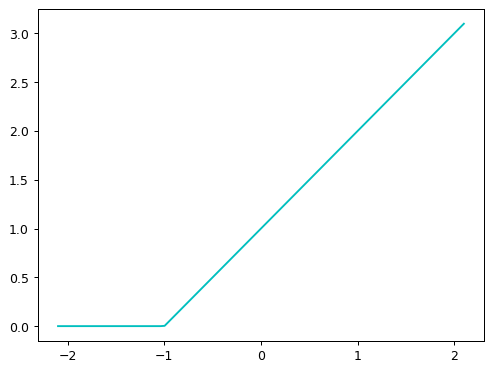

In [42]:
#this rectifier is the same as relu so we use it from now on
import torch.nn.functional as F #this F refer to the torch.nn.functional modula
#relu function
def rectified_linear2(m2,b2,x): 
    relu=F.relu(m2*x+b2)
    return relu

plot_function(partial(rectified_linear2, 1,1))
#this is what happens in a single layer of a neural network

In [43]:
#equivalently in 1 layer(a neuron) of nn we have:
layer=nn.Linear(in_features=1, out_features=1)
activation=F.relu(layer(x3))
